<h3>Анализ активности студентов онлайн курса Введение в анализ данных в R</h3>

Задача: на ранней стадии выявить тех студентов курса, которые могут его забросить 

Описание данных:

events_train.csv - данные о действиях, которые совершают студенты со стэпами

https://stepik.org/media/attachments/course/4852/event_data_train.zip

step_id - id стэпа user_id - анонимизированный id юзера timestamp - время наступления события в формате unix date action - событие, возможные значения: discovered - пользователь перешел на стэп viewed - просмотр шага, started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага passed - удачное решение практического шага 

submissions_train.csv - данные о времени и статусах сабмитов к практическим заданиям

https://stepik.org/media/attachments/course/4852/submissions_data_train.zip

step_id - id стэпа timestamp - время отправки решения в формате unix date submission_status - статус решения user_id - анонимизированный id юзера

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
events_data = pd.read_csv('event_data_train.csv')

In [4]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [5]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


Получаю даты для следующего анализа

In [6]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')

In [7]:
submissions_data['day'] = submissions_data.date.dt.date

In [8]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [9]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [10]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

'viewed' - посмотреть, 'passed' - решить, 'discovered' - впервые увидеть, 'started_attempt' - начать решать

In [11]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [12]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [13]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [14]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [15]:
events_data['day'] = events_data.date.dt.date

In [16]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Количество записавшихся на курс по дням

<AxesSubplot:xlabel='day'>

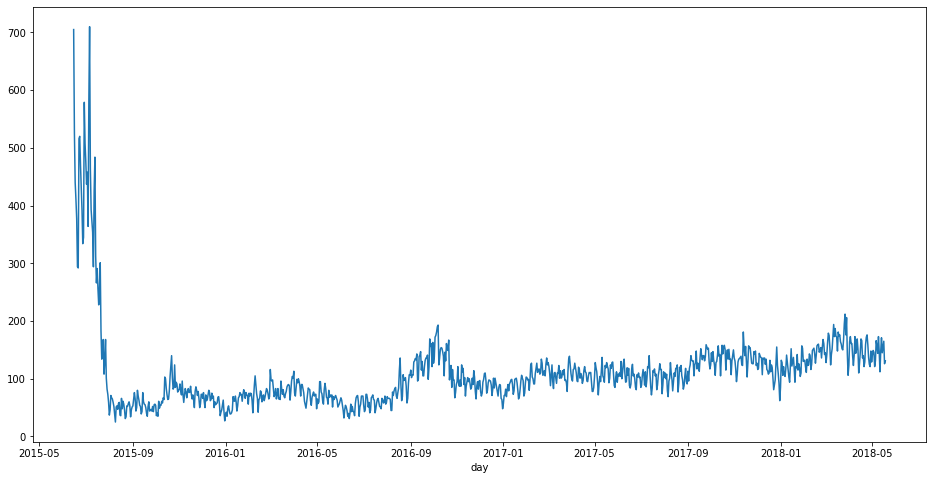

In [17]:
events_data.groupby('day') \
    .user_id.nunique().plot(figsize=(16,8))

Распределение пользователей по количеству полученных баллов

<AxesSubplot:>

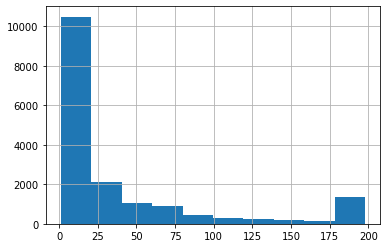

In [18]:
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'}).passed_steps.hist()

Анализ шагов пользователей

In [19]:
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [20]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Количество павильных/неправильных попыток

In [21]:
users_scores = submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [22]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Определение предельного значения, когда пользователя уже можно считать покинувшим курс

Разница во времени посещений пользователями платформы

In [23]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [24]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

Разница в днях

In [25]:
gap_data = gap_data / (24 * 60 *60)

Распределение разницы между отдельными посещениями

<AxesSubplot:>

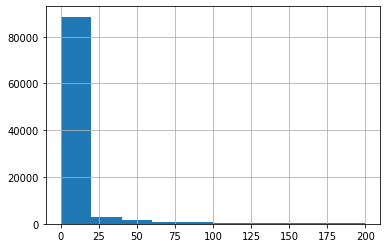

In [26]:
gap_data[gap_data < 200].hist()

Только 7.5% пользователей возвращаются на курс после перерыва в месяц

In [27]:
gap_data.quantile(0.925)

30.629370081018546

In [28]:
drop_out_threshold = 30 * 24 * 60 * 60

In [29]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


Последнее действие пользователя

In [30]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

Условное "сейчас"

In [31]:
now = 1526772811

Определяем пользователей, которые, скорее всего, не вернутся на курс

In [32]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [33]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


Добавляю в данным пользователей информацию об их правильных/неправильных решениях

In [34]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [35]:
users_data = users_data.fillna(0)

In [36]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


Добавляю в данным пользователей информацию об их шагах

In [37]:
users_data = users_data.merge(users_events_data, how='outer')

К-во дней пребывания пользователей на курсе

In [38]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [39]:
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [40]:
users_data = users_data.merge(users_days, how='outer')

In [41]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [42]:
users_data.user_id.nunique()

19234

In [43]:
events_data.user_id.nunique()

19234

Определение пользователей, которые получили сертификат о завершении курса

In [44]:
users_data['passed_course'] = users_data.passed > 170

In [45]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [46]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


Процент пользователей, получивших сертификат

In [47]:
1425 / 17809 * 100

8.001572238755687

Распределение к-ва уникальных дней для пользователей, получивших сертификат

<AxesSubplot:>

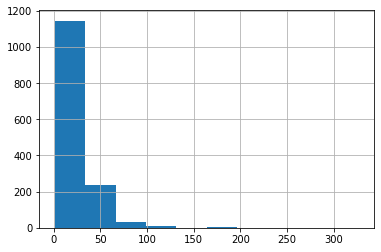

In [48]:
users_data[users_data.passed_course].day.hist()

Определение первого дня на курсе

In [49]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [50]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [51]:
users_data = users_data.merge(user_min_time, how='outer')

In [52]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [53]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Определение стэпов пользователей, в первые 3 дня

In [54]:
events_data_train = pd.DataFrame()

In [55]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [56]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [57]:
learning_time_threshold = 3 * 24 * 60 * 60
learning_time_threshold

259200

In [58]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

In [59]:
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [60]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [61]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [62]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [63]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [64]:
events_data_train.groupby('user_id').day.nunique().max()

4

Определение решений пользователей, в первые 3 дня

In [65]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

Подготовка тренировочного датасета

In [66]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename({'user_id': 'days'})

In [67]:
X.head()

,user_id,day
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


Количество задействованных шагов пользователем

In [68]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'steps_tried'})

In [69]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [70]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [71]:
X.head()

,user_id,day,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [72]:
X = X.merge(submissions_data_train.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

Доля правильных ответов

In [73]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [74]:
X.head()

,user_id,day,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [75]:
X = X.merge(events_data_train.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [76]:
X = X.fillna(0)

In [77]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [78]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [79]:
X.head()

,user_id,day,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Исключить тех, кто не закончил курс и не покинул его

In [80]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [81]:
X.head()

,user_id,day,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [82]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [83]:
y = X.passed_course.map(int)

In [84]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [85]:
X = X.set_index(X.user_id)

In [86]:
X = X.drop(['user_id'], axis=1)

In [87]:
X.head()

,day,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


Применяю алгоритм случайного леса

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
from sklearn.model_selection import GridSearchCV

In [90]:
from sklearn.model_selection import RandomizedSearchCV

In [91]:
clf = RandomForestClassifier()

Начало подбора параметров

In [92]:
random_parametrs = {'n_estimators': range(2, 600, 50), 
                    'max_depth': range(2, 600, 50), 
                    'min_samples_split': range(2, 600, 50), 'min_samples_leaf': range(2, 600, 50)}

In [93]:
random_search_cv_clf = RandomizedSearchCV(clf, random_parametrs, cv=5)

In [94]:
random_search_cv_clf.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': range(2, 600, 50),
                                        'min_samples_leaf': range(2, 600, 50),
                                        'min_samples_split': range(2, 600, 50),
                                        'n_estimators': range(2, 600, 50)})

In [95]:
random_search_cv_clf.best_params_

{'n_estimators': 252,
 'min_samples_split': 252,
 'min_samples_leaf': 502,
 'max_depth': 102}

In [96]:
random_parametrs = {'n_estimators': range(random_search_cv_clf.best_params_['n_estimators'] - 50, random_search_cv_clf.best_params_['n_estimators'] + 50, 20), 
                    'min_samples_split': range(random_search_cv_clf.best_params_['min_samples_split'] - 50, random_search_cv_clf.best_params_['min_samples_split'] + 50, 20), 
                    'min_samples_leaf': range(random_search_cv_clf.best_params_['min_samples_leaf'] - 50, random_search_cv_clf.best_params_['min_samples_leaf'] + 50, 20),
                    'max_depth': range(random_search_cv_clf.best_params_['max_depth'] - 50, random_search_cv_clf.best_params_['max_depth'] + 50, 20)}

In [97]:
random_search_cv_clf = RandomizedSearchCV(clf, random_parametrs, cv=5)

In [98]:
random_search_cv_clf.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': range(52, 152, 20),
                                        'min_samples_leaf': range(452, 552, 20),
                                        'min_samples_split': range(202, 302, 20),
                                        'n_estimators': range(202, 302, 20)})

In [99]:
random_search_cv_clf.best_params_

{'n_estimators': 242,
 'min_samples_split': 222,
 'min_samples_leaf': 492,
 'max_depth': 112}

In [100]:
random_parametrs = {'n_estimators': range(random_search_cv_clf.best_params_['n_estimators'] - 20, random_search_cv_clf.best_params_['n_estimators'] + 20, 5), 
                    'min_samples_split': range(random_search_cv_clf.best_params_['min_samples_split'] - 20, random_search_cv_clf.best_params_['min_samples_split'] + 20, 5), 
                    'min_samples_leaf': range(random_search_cv_clf.best_params_['min_samples_leaf'] - 20, random_search_cv_clf.best_params_['min_samples_leaf'] + 20, 5),
                    'max_depth': range(random_search_cv_clf.best_params_['max_depth'] - 20, random_search_cv_clf.best_params_['max_depth'] + 20, 5)}

In [101]:
random_search_cv_clf = RandomizedSearchCV(clf, random_parametrs, cv=5)

In [102]:
random_search_cv_clf.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': range(92, 132, 5),
                                        'min_samples_leaf': range(472, 512, 5),
                                        'min_samples_split': range(202, 242, 5),
                                        'n_estimators': range(222, 262, 5)})

In [103]:
random_search_cv_clf.best_params_

{'n_estimators': 232,
 'min_samples_split': 237,
 'min_samples_leaf': 487,
 'max_depth': 102}

In [104]:
random_parametrs = {'n_estimators': range(random_search_cv_clf.best_params_['n_estimators'] - 5, random_search_cv_clf.best_params_['n_estimators'] + 5), 
                    'min_samples_split': range(random_search_cv_clf.best_params_['min_samples_split'] - 5, random_search_cv_clf.best_params_['min_samples_split'] + 5), 
                    'min_samples_leaf': range(random_search_cv_clf.best_params_['min_samples_leaf'] - 5, random_search_cv_clf.best_params_['min_samples_leaf'] + 5),
                    'max_depth': range(random_search_cv_clf.best_params_['max_depth'] - 5, random_search_cv_clf.best_params_['max_depth'] + 5)}

In [105]:
random_search_cv_clf = RandomizedSearchCV(clf, random_parametrs, cv=5)

In [106]:
random_search_cv_clf.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': range(97, 107),
                                        'min_samples_leaf': range(482, 492),
                                        'min_samples_split': range(232, 242),
                                        'n_estimators': range(227, 237)})

In [107]:
random_search_cv_clf.best_params_

{'n_estimators': 230,
 'min_samples_split': 238,
 'min_samples_leaf': 490,
 'max_depth': 100}

In [108]:
random_parametrs = {'n_estimators': random_search_cv_clf.best_params_['n_estimators'], 
                    'min_samples_split': random_search_cv_clf.best_params_['min_samples_split'], 
                    'min_samples_leaf': random_search_cv_clf.best_params_['min_samples_leaf'], 
                    'max_depth': random_search_cv_clf.best_params_['max_depth']}

In [109]:
best_estimator = random_search_cv_clf.best_estimator_

In [110]:
best_estimator.score(X, y)

0.920767306088407

Идентичная подготовка тестового датасета

In [111]:
events_data_test = pd.read_csv('events_data_test.csv')

In [112]:
submissions_data_test = pd.read_csv('submission_data_test.csv')

In [113]:
submissions_data_test.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


In [114]:
submissions_data_test['date'] = pd.to_datetime(submissions_data_test.timestamp, unit='s')

In [115]:
submissions_data_test['day'] = submissions_data_test.date.dt.date

In [116]:
submissions_data_test.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20
3,31971,1526801054,correct,24370,2018-05-20 07:24:14,2018-05-20
4,31972,1526800664,wrong,24370,2018-05-20 07:17:44,2018-05-20


In [117]:
events_data_test.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [118]:
events_data_test['date'] = pd.to_datetime(events_data_test.timestamp, unit='s')

In [119]:
events_data_test.head()

,step_id,timestamp,action,user_id,date
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47


In [120]:
events_data_test.date.min()

Timestamp('2018-05-20 03:59:01')

In [121]:
events_data_test.date.max()

Timestamp('2019-01-20 17:00:43')

In [122]:
events_data_test['day'] = events_data_test.date.dt.date

In [123]:
events_data_test.head()

,step_id,timestamp,action,user_id,date,day
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21


<AxesSubplot:xlabel='day'>

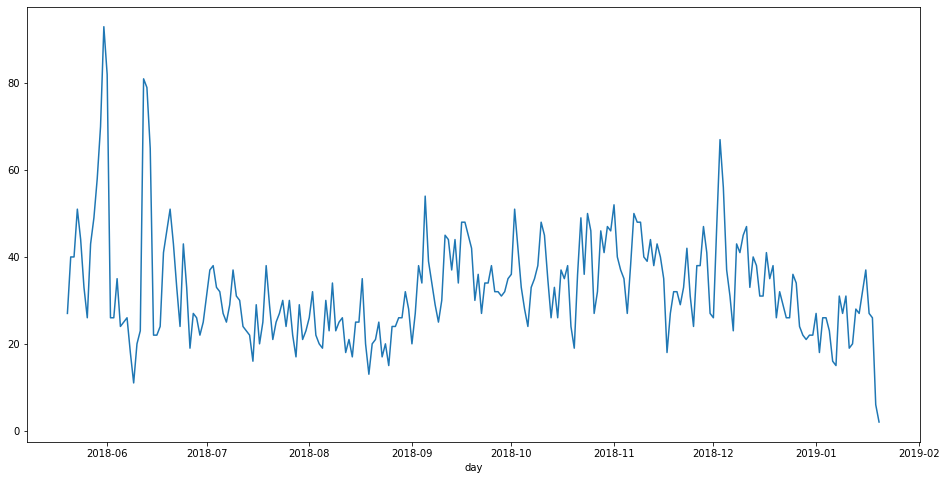

In [124]:
events_data_test.groupby('day') \
    .user_id.nunique().plot(figsize=(16,8))

In [125]:
users_events_data_test = events_data_test.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [126]:
users_events_data_test.head()

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6
3,12,11,9,4,14
4,13,70,70,35,105


In [127]:
users_scores_test = submissions_data_test.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [128]:
users_scores_test.head()

submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,36
2,15,10,30
3,21,24,103
4,35,7,35


In [129]:
users_data_test = events_data_test.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [130]:
users_data_test = users_data_test.merge(users_scores_test, on='user_id', how='outer')

In [131]:
users_data_test = users_data_test.fillna(0)

In [132]:
users_data_test.head()

,user_id,last_timestamp,correct,wrong
0,4,1529331707,0.0,0.0
1,6,1546889407,0.0,0.0
2,10,1534593770,0.0,0.0
3,12,1537348641,1.0,0.0
4,13,1533162170,29.0,36.0


In [133]:
users_data_test = users_data_test.merge(users_events_data_test, how='outer')

In [134]:
users_days_test = events_data_test.groupby('user_id').day.nunique().to_frame().reset_index()

In [135]:
users_days_test.head()

,user_id,day
0,4,1
1,6,1
2,10,1
3,12,1
4,13,2


In [136]:
users_data_test = users_data_test.merge(users_days_test, how='outer')

In [137]:
users_data_test.head()

,user_id,last_timestamp,correct,wrong,discovered,passed,started_attempt,viewed,day
0,4,1529331707,0.0,0.0,1,1,0,1,1
1,6,1546889407,0.0,0.0,1,1,0,1,1
2,10,1534593770,0.0,0.0,2,2,0,6,1
3,12,1537348641,1.0,0.0,11,9,4,14,1
4,13,1533162170,29.0,36.0,70,70,35,105,2


In [138]:
user_min_time_test = events_data_test.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [139]:
user_min_time_test.head()

,user_id,min_timestamp
0,4,1529331707
1,6,1546889407
2,10,1534585756
3,12,1537348474
4,13,1533034354


In [140]:
users_data_test = users_data_test.merge(user_min_time_test, how='outer')

In [141]:
events_data_test['user_time'] = events_data_test.user_id.map(str) + '_' + events_data_test.timestamp.map(str)

In [142]:
events_data_test.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21,24417_1526893787
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21,24417_1526893797
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21,24417_1526893954
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21,24417_1526895780
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21,24417_1526893787


In [143]:
user_learning_time_threshold_test = user_min_time_test.user_id.map(str) + '_' + (user_min_time_test.min_timestamp + learning_time_threshold).map(str)

In [144]:
user_learning_time_threshold_test.head()

0     4_1529590907
1     6_1547148607
2    10_1534844956
3    12_1537607674
4    13_1533293554
dtype: object

In [145]:
user_min_time_test['user_learning_time_threshold'] = user_learning_time_threshold_test

In [146]:
events_data_test = events_data_test.merge(user_min_time_test[['user_id', 'user_learning_time_threshold']], how='outer')

In [147]:
events_data_train_test = pd.DataFrame()

In [148]:
events_data_train_test = events_data_test[events_data_test.user_time <= events_data_test.user_learning_time_threshold]

In [149]:
events_data_train_test.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21,24417_1526893787,24417_1527152639
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21,24417_1526893797,24417_1527152639
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21,24417_1526893954,24417_1527152639
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21,24417_1526895780,24417_1527152639
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21,24417_1526893787,24417_1527152639


In [150]:
events_data_train_test.groupby('user_id').day.nunique().max()

3

In [151]:
submissions_data_test['users_time'] = submissions_data_test.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data_test = submissions_data_test.merge(user_min_time_test[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train_test = submissions_data_test[submissions_data_test.users_time <= submissions_data_test.user_learning_time_threshold]
submissions_data_train_test.groupby('user_id').day.nunique().max()

3

In [152]:
X_test = submissions_data_train_test.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename({'user_id': 'days'})

In [153]:
X_test.head()

,user_id,day
0,12,1
1,13,2
2,15,3
3,21,1
4,35,3


In [154]:
steps_tried_test = submissions_data_train_test.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'steps_tried'})

In [155]:
steps_tried_test.head()

,user_id,steps_tried
0,12,1
1,13,29
2,15,11
3,21,30
4,35,9


In [156]:
X_test = X_test.merge(steps_tried_test, on='user_id', how='outer')

In [157]:
X_test.head()

,user_id,day,steps_tried
0,12,1,1
1,13,2,29
2,15,3,11
3,21,1,30
4,35,3,9


In [158]:
X_test = X_test.merge(submissions_data_train_test.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

In [159]:
X_test['correct_ratio'] = X_test.correct / (X_test.correct + X_test.wrong)

In [160]:
X_test.head()

,user_id,day,steps_tried,correct,wrong,correct_ratio
0,12,1,1,1,0,1.000000
1,13,2,29,29,36,0.446154
2,15,3,11,10,30,0.250000
3,21,1,30,24,103,0.188976
4,35,3,9,7,35,0.166667


In [161]:
X_test = X_test.merge(events_data_train_test.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [162]:
X_test = X_test.fillna(0)

In [163]:
users_data_test.head()

,user_id,last_timestamp,correct,wrong,discovered,passed,started_attempt,viewed,day,min_timestamp
0,4,1529331707,0.0,0.0,1,1,0,1,1,1529331707
1,6,1546889407,0.0,0.0,1,1,0,1,1,1546889407
2,10,1534593770,0.0,0.0,2,2,0,6,1,1534585756
3,12,1537348641,1.0,0.0,11,9,4,14,1,1537348474
4,13,1533162170,29.0,36.0,70,70,35,105,2,1533034354


In [164]:
X_test = X_test.merge(users_data_test['user_id'], how='outer')

In [165]:
X_test.head()

,user_id,day,steps_tried,correct,wrong,correct_ratio,viewed
0,12,1.0,1.0,1.0,0.0,1.000000,14
1,13,2.0,29.0,29.0,36.0,0.446154,105
2,15,3.0,11.0,10.0,30.0,0.250000,1
3,21,1.0,30.0,24.0,103.0,0.188976,98
4,35,3.0,9.0,7.0,35.0,0.166667,70


In [166]:
X_test = X_test.set_index(X_test.user_id)

In [167]:
X_test = X_test.drop('user_id', axis=1)

In [168]:
X_test.head()

,day,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
12,1.0,1.0,1.0,0.0,1.000000,14
13,2.0,29.0,29.0,36.0,0.446154,105
15,3.0,11.0,10.0,30.0,0.250000,1
21,1.0,30.0,24.0,103.0,0.188976,98
35,3.0,9.0,7.0,35.0,0.166667,70


In [169]:
best_estimator.predict_proba(X_test)

array([[0.94874324, 0.05125676],
       [0.60006406, 0.39993594],
       [0.830469  , 0.169531  ],
       ...,
       [0.98693711, 0.01306289],
       [0.98693711, 0.01306289],
       [0.98693711, 0.01306289]])

In [170]:
from sklearn.metrics import roc_auc_score

In [171]:
pred_proba = best_estimator.predict_proba(X)

In [172]:
roc_score = roc_auc_score(y, pred_proba[:, 1])

In [173]:
roc_score

0.8449932833290956

In [174]:
test_proba = best_estimator.predict_proba(X_test)

In [175]:
X_test.index.values

array([   12,    13,    15, ..., 26791, 26795, 26800], dtype=int64)

In [176]:
test_proba[:, 1]

array([0.05125676, 0.39993594, 0.169531  , ..., 0.01306289, 0.01306289,
       0.01306289])

In [177]:
res = pd.DataFrame({'user_id': X_test.index.values, 'is_gone': test_proba[:, 1]})

In [178]:
res.to_csv('result.csv', sep=',', index=False)

In [179]:
#Your ROC score is 0.8860464896343875